In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/n9455647/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
from DatasetManager import DatasetManager

import pandas as pd
import numpy as np

import os
import sys
from sys import argv
import pickle
import random
import joblib

import statistics

import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dataset_ref = "bpic2012"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "single"
cls_encoding = "agg"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
max_feat = 10

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"]
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['bpic2012_accepted']

Bucket 1
True Negatives
Average LIME Stability: 0.8150319713261649
Average SHAP Stability: 1.0


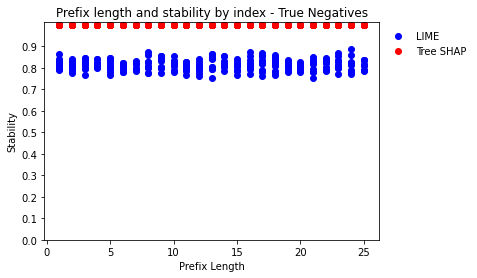

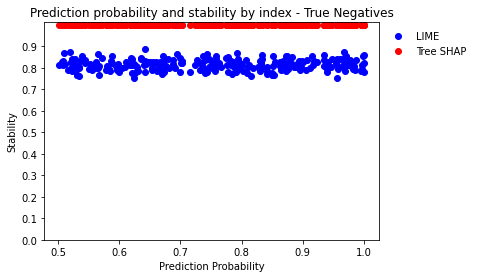

True Positives
Average LIME Stability: 0.8172124731182795
Average SHAP Stability: 1.0


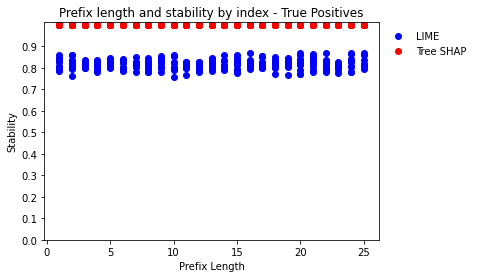

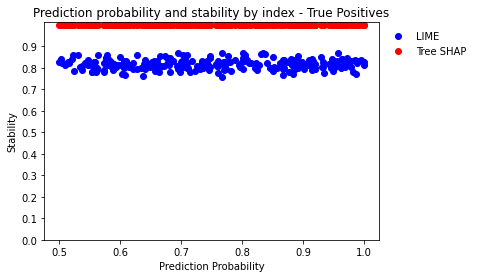

False Negatives
Average LIME Stability: 0.8130627956989247
Average SHAP Stability: 1.0


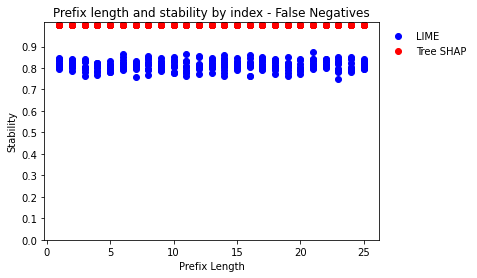

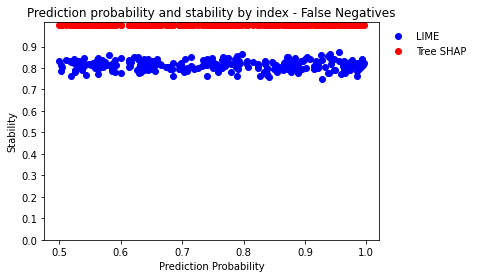

False Positives
Average LIME Stability: 0.813178064516129
Average SHAP Stability: 1.0


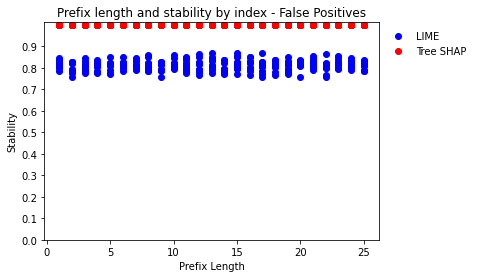

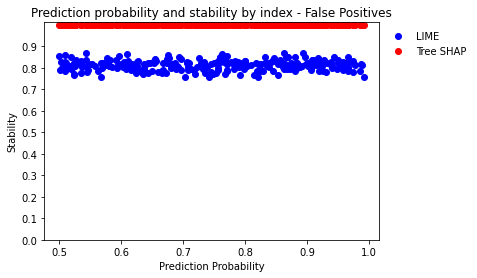

In [5]:
all_caseID = []
all_lengths = []
all_proba = []
all_lime_stab = []
all_shap_stab = []

for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = range(len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))]))

        for bucket in list(num_buckets):
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            with open (fn_path, 'rb') as f:
                fn_list = pickle.load(f)
            with open (fp_path, 'rb') as f:
                fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            sample_instances.append(fn_list)
            sample_instances.append(fp_list)
            
            type_list = ["True Negatives", "True Positives", "False Negatives", "False Positives"]
            
            for i in range(len(sample_instances)):
                print (type_list[i])
                data = pd.DataFrame.from_records(sample_instances[i])
                
                case_id = pd.Series(data['caseID'])
                nr_events = pd.Series(data['nr_events'])
                proba = pd.Series(data['proba'])
                lime_stability = pd.Series(data['lime_stability'])
                tree_shap_stability = pd.Series(data['tree_shap_stability'])
                
                all_caseID.extend(case_id)
                all_lengths.extend(nr_events)
                all_proba.extend(proba)
                all_lime_stab.extend(lime_stability)
                all_shap_stab.extend(tree_shap_stability)
                
                print("Average LIME Stability:", statistics.mean(lime_stability))
                print("Average SHAP Stability:", statistics.mean(tree_shap_stability))
                
                fig, ax = plt.subplots()
                ax.plot(nr_events, lime_stability, 'bo', label = "LIME")
                ax.plot(nr_events, tree_shap_stability, 'ro', label = "Tree SHAP")
                ax.set_xlabel("Prefix Length")
                ax.set_ylabel("Stability")
                ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                plt.yticks(np.arange(0,1, 0.1))
                plt.title("Prefix length and stability by index - "+type_list[i])
                plt.show()
                
                fig2, ax2 = plt.subplots()
                ax2.plot(proba, lime_stability, 'bo', label = "LIME")
                ax2.plot(proba, tree_shap_stability, 'ro', label = "Tree SHAP")
                ax2.set_xlabel("Prediction Probability")
                ax2.set_ylabel("Stability")
                ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                plt.yticks(np.arange(0,1, 0.1))
                plt.title("Prediction probability and stability by index - "+type_list[i])
                plt.show()

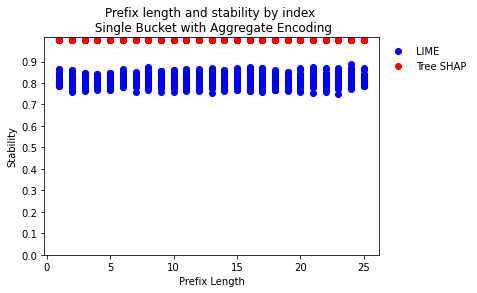

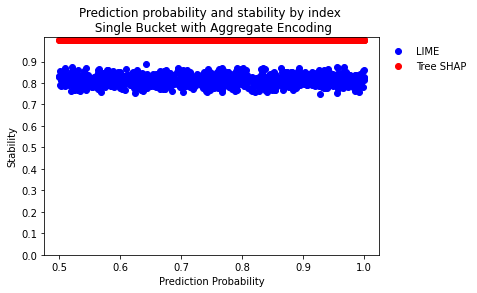

In [6]:
fig, ax = plt.subplots()
ax.plot(all_lengths, all_lime_stab, 'bo', label = "LIME")
ax.plot(all_lengths, all_shap_stab, 'ro', label = "Tree SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Stability")
ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1, 0.1))
plt.title("Prefix length and stability by index \n Single Bucket with Aggregate Encoding")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_proba, all_lime_stab, 'bo', label = "LIME")
ax2.plot(all_proba, all_shap_stab, 'ro', label = "Tree SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Stability")
ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1, 0.1))
plt.title("Prediction probability and stability by index \n Single Bucket with Aggregate Encoding")
plt.show()

Bucket 1
True Negatives
Average LIME Weights Stability: 0.135580800367917
Average SHAP Weights Stability: 1.0879561846742964e-16
250


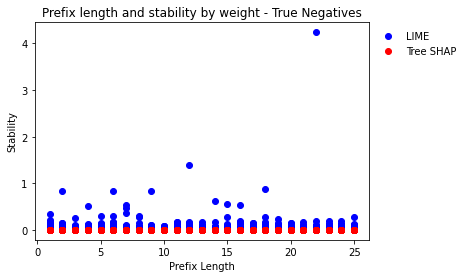

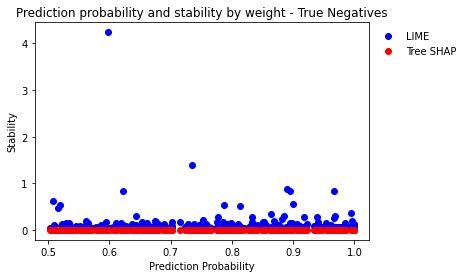

True Positives
Average LIME Weights Stability: 0.12692967919784334
Average SHAP Weights Stability: 1.1244795097583007e-16
250


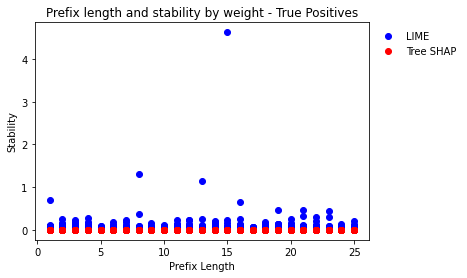

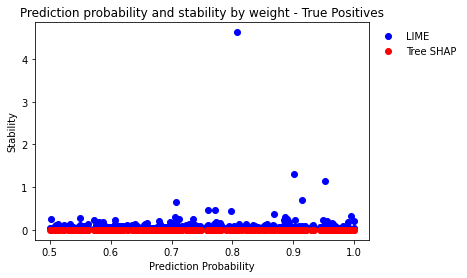

False Negatives
Average LIME Weights Stability: 0.1660601597488902
Average SHAP Weights Stability: 1.0564304324928286e-16
250


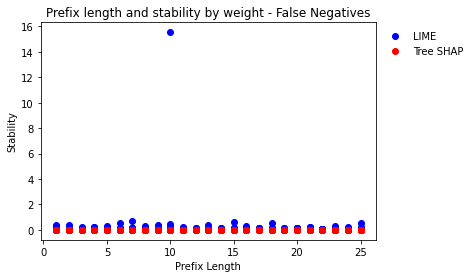

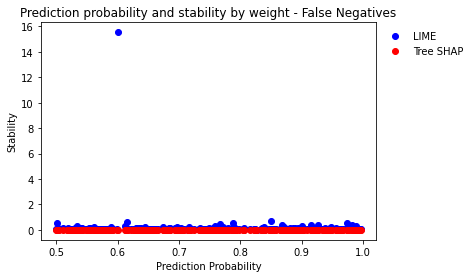

False Positives
Average LIME Weights Stability: 0.15290253049634459
Average SHAP Weights Stability: 1.0862217124694575e-16
250


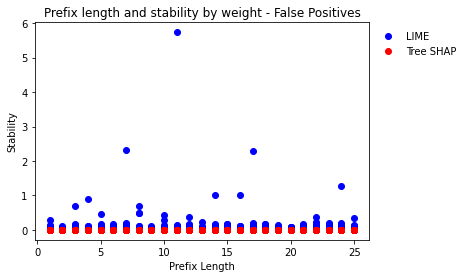

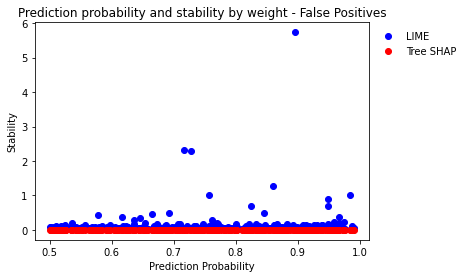

In [7]:
all_caseID = []
all_lengths = []
all_proba = []
all_lime_stab = []
all_shap_stab = []

for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = range(len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))]))

        for bucket in list(num_buckets):
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            with open (fn_path, 'rb') as f:
                fn_list = pickle.load(f)
            with open (fp_path, 'rb') as f:
                fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            sample_instances.append(fn_list)
            sample_instances.append(fp_list)
            
            type_list = ["True Negatives", "True Positives", "False Negatives", "False Positives"]
            
            for i in range(len(sample_instances)):
                print (type_list[i])
                data = pd.DataFrame.from_records(sample_instances[i])
                
                dispersal_lime = []
                dispersal_shap = []
                adj_dispersal_lime = []
                adj_dispersal_shap = []
                
                case_id = pd.Series(data['caseID'])
                nr_events = pd.Series(data['nr_events'])
                proba = pd.Series(data['proba'])
                lime_stability = pd.Series(data['adjusted_lime_importance_stability'])
                tree_shap_stability = pd.Series(data['adjusted_shap_importance_stability'])
                
                all_caseID.extend(case_id)
                all_lengths.extend(nr_events)
                all_proba.extend(proba)
                all_lime_stab.extend(lime_stability)
                all_shap_stab.extend(tree_shap_stability)
                
                print("Average LIME Weights Stability:", statistics.mean(lime_stability))
                print("Average SHAP Weights Stability:", statistics.mean(tree_shap_stability))
                
                shap_dispersion = [disp for disp in tree_shap_stability if disp > 0]
                
                print (len(shap_dispersion))
                
                fig, ax = plt.subplots()
                ax.plot(nr_events, lime_stability, 'bo', label = "LIME")
                ax.plot(nr_events, tree_shap_stability, 'ro', label = "Tree SHAP")
                ax.set_xlabel("Prefix Length")
                ax.set_ylabel("Stability")
                ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                plt.title("Prefix length and stability by weight - "+type_list[i])
                plt.show()
                
                fig2, ax2 = plt.subplots()
                ax2.plot(proba, lime_stability, 'bo', label = "LIME")
                ax2.plot(proba, tree_shap_stability, 'ro', label = "Tree SHAP")
                ax2.set_xlabel("Prediction Probability")
                ax2.set_ylabel("Stability")
                ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                plt.title("Prediction probability and stability by weight - "+type_list[i])
                plt.show()

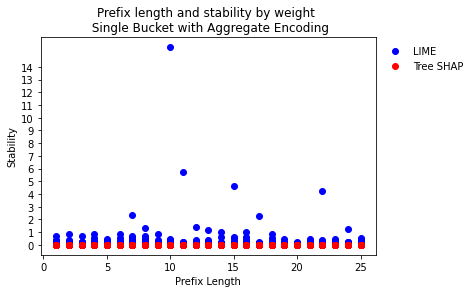

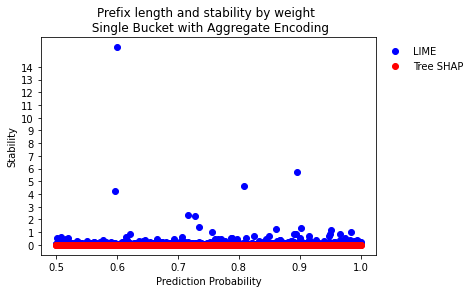

In [8]:
fig, ax = plt.subplots()
ax.plot(all_lengths, all_lime_stab, 'bo', label = "LIME")
ax.plot(all_lengths, all_shap_stab, 'ro', label = "Tree SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Stability")
ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and stability by weight \n Single Bucket with Aggregate Encoding")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_proba, all_lime_stab, 'bo', label = "LIME")
ax2.plot(all_proba, all_shap_stab, 'ro', label = "Tree SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Stability")
ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and stability by weight \n Single Bucket with Aggregate Encoding")
plt.show()

In [9]:
lime_mean = np.mean(all_lime_stab)
lime_std = np.std(all_lime_stab)
lime_upper = lime_mean + (3*lime_std)
lime_lower = lime_mean - (3*lime_std)

shap_mean = np.mean(all_shap_stab)
shap_std = np.std(all_shap_stab)
shap_upper = shap_mean + (3*shap_std)
shap_lower = shap_mean - (3*shap_std)

lime_outliers = [i for i in all_lime_stab if i > lime_upper or i < lime_lower]
shap_outliers = [i for i in all_shap_stab if i > shap_upper or i < shap_lower]

print (lime_mean)
print (shap_mean)
print(len(lime_outliers))
print(len(shap_outliers))
print(str(len(lime_outliers)/len(all_lime_stab)*100)+"%")
print(str(len(shap_outliers)/len(all_shap_stab)*100)+"%")

0.1453682924527488
1.0887719598487206e-16
6
9
0.6%
0.8999999999999999%


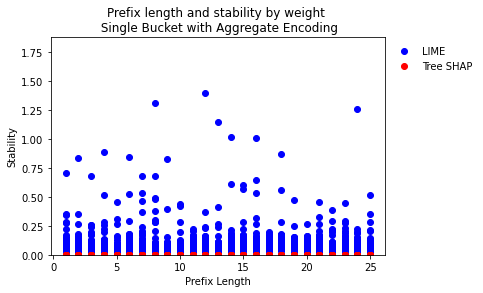

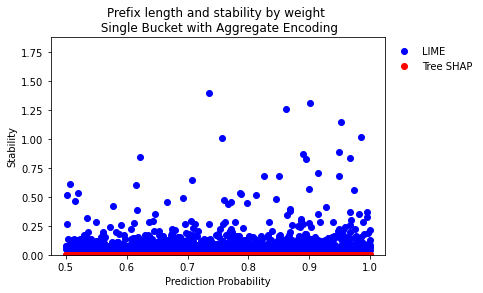

In [10]:
fig, ax = plt.subplots()
ax.plot(all_lengths, all_lime_stab, 'bo', label = "LIME")
ax.plot(all_lengths, all_shap_stab, 'ro', label = "Tree SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Stability")
ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.ylim(0, lime_upper)
plt.title("Prefix length and stability by weight \n Single Bucket with Aggregate Encoding")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_proba, all_lime_stab, 'bo', label = "LIME")
ax2.plot(all_proba, all_shap_stab, 'ro', label = "Tree SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Stability")
ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.ylim(0, lime_upper)
plt.title("Prefix length and stability by weight \n Single Bucket with Aggregate Encoding")
plt.show()

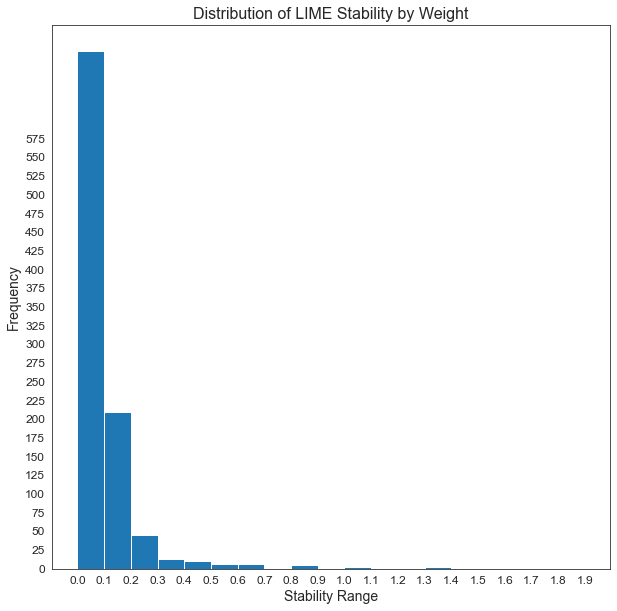

In [11]:
bins = np.arange(0, lime_upper+0.1, 0.1)
yticks = np.arange(0, 600, 25)
sns.set_style("white")
plt.subplots(figsize=(10, 10))
plt.hist(all_lime_stab, bins = bins)
#plt.figsize([50, 50])
plt.xticks(bins, fontsize = 12)
plt.yticks(yticks, fontsize = 12)
plt.title("Distribution of LIME Stability by Weight", fontsize = 16)
plt.xlabel("Stability Range", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.show()

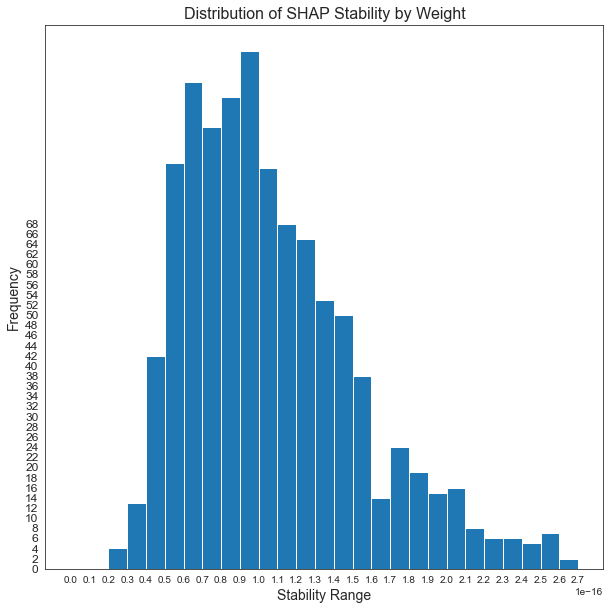

In [12]:
bins = np.arange(0, shap_upper+1e-17, 1e-17)
yticks = np.arange(0, 70, 2)
sns.set_style("white")
plt.subplots(figsize=(10, 10))
plt.hist(all_shap_stab, bins = bins)
#plt.figsize([50, 50])
plt.xticks(bins)
          #, fontsize = 8)
plt.yticks(yticks, fontsize = 12)
plt.title("Distribution of SHAP Stability by Weight", fontsize = 16)
plt.xlabel("Stability Range", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.show()